# PyTorch Computing Vision

# Computer vision libraries in PyTorch
* torchvision - base domain library
* torchvision.datasets - datasets and data loading function for computer vision
* torchvision.models - get pretrained computer vision models
* torchvision.transforms - perform common image transformations for computer vision
* torch.utils.data.Dataset - base dataset class for PyTorch
* torch.utils.data.DataLoader - creates a python iterable over a dataset

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

# Getting a computer vision dataset and see it inputs and outputs

will use: FashionMNIST database

In [2]:
# Setup Training Data
train_data = datasets.FashionMNIST(
    root="data", # where to download to
    train=True, # the training data, false is test data
    download=True,
    transform=ToTensor(), # transform images into tensors
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False, # the test data
    download=True,
    transform=ToTensor(), # transform images into tensors
    target_transform=None
)


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 170kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.21MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.79MB/s]


In [3]:
len(train_data)

60000

In [4]:
# See the first training example
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [5]:
img , lbl = test_data[0]
img.shape, lbl

(torch.Size([1, 28, 28]), 9)

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

# Visualizing our data

Text(0.5, 1.0, '9')

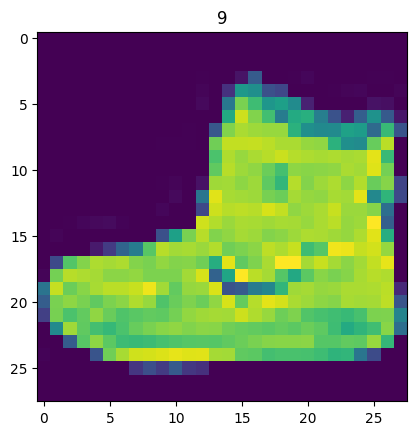

In [7]:
plt.imshow(image.squeeze())
plt.title(label)

Text(0.5, 1.0, 'Ankle boot')

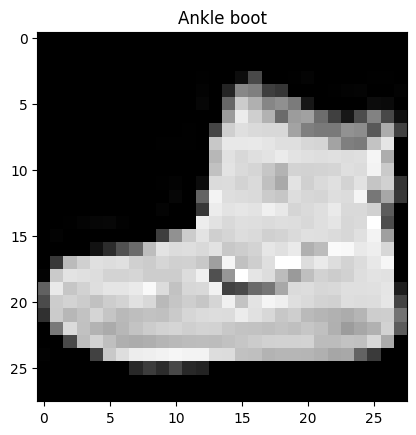

In [8]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

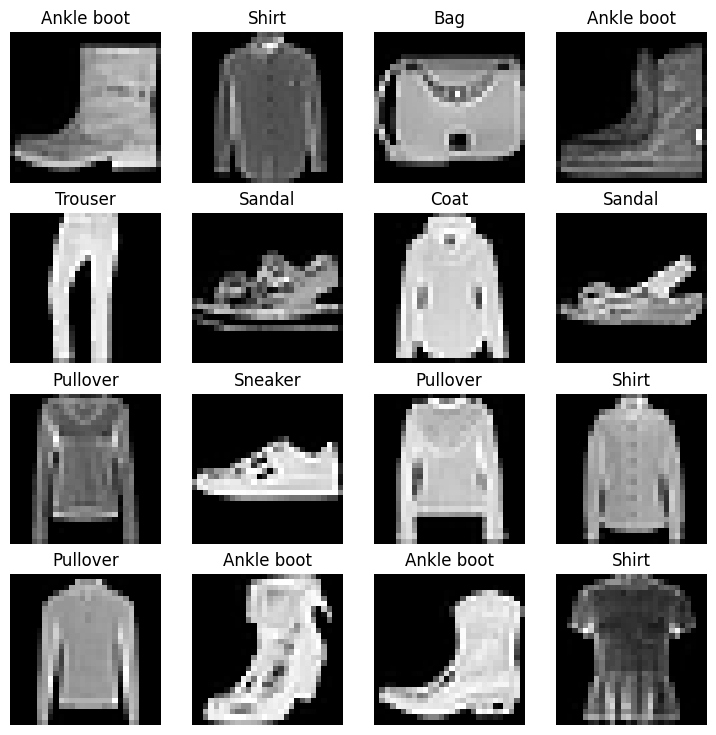

In [9]:
# Plot more images
torch.manual_seed(42)

fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4

for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

# Prepare DataLoader

Right now, our data is in the form of PyTorch datasets

DataLoader turns our data into a Python iterable

More specifically, we want to turn our data into batches (mini-batches)

* it is more computationally efficient, the computing hardware may not be able to look at 6000 images in one hit. So we break it down to 32 images at a times
* it gives our NN more chances to update irs gradients per epoch

In [10]:
from torch.utils.data import DataLoader

# Setupthe batch sie hyperparameter
BATCH_SIZE = 32

# Turn datasets into interables (batches)

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d0639cc4e10>,
 <torch.utils.data.dataloader.DataLoader at 0x7d0639b1b9d0>)

In [11]:
# Check whats inside the DataLoader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [63]:
!nvidia-smi


Tue Jul  8 16:10:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P0             31W /   70W |     166MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
len(train_features_batch)

32

img size torch.Size([1, 28, 28])


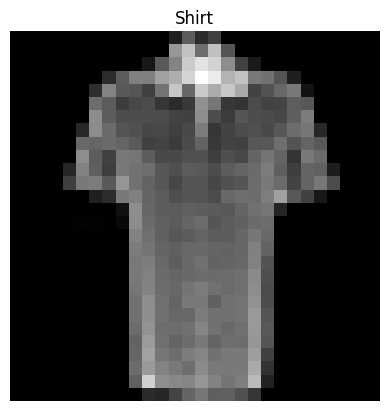

In [13]:
# Show a sample

torch.manual_seed(42)
random_idx = torch.randint(len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"img size {img.shape}")


# Model 0: Build a basline model

When starting to build a series of machine learning modelling experiments, it's best practic to start with a baseline model


Start simply and add complexity when necessary

In [14]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]
x.shape

# Flatten the sample
output = flatten_model(x) # perform forward pass
x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [15]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
     super().__init__()
     self.layer_stack = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=input_shape, out_features=hidden_units),
      nn.Linear(in_features=hidden_units, out_features=output_shape)
     )

  def forward(self, x):
    return self.layer_stack(x)


In [16]:
torch.manual_seed(42)

# Setu pmodel with input params

model_0 = FashionMNISTModelV0(
    input_shape=784, # 28*28
    hidden_units=10, # how many units in the hidden layer
    output_shape=len(class_names) #one for every class
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [17]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)


tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

# Setup loss, optimizer, and evaluation metrics

* Loss function - for multi-class data, will use `nn.CrossEntropyLoss()`
* Optimizer - `torch.optim.SGD()`
* Evaluation metric - for a classification problem, will use accuracy

In [18]:
import requests
from pathlib import Path

# Download helper function


if not Path("helper_functions.py").is_file():
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


In [19]:
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

# Create a function to time our experiments

Track:
* model performance
* how fast it runs

In [20]:
from timeit import default_timer as timer
def train_time(start: float, end: float, device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [21]:
start_time = timer()
#code
end_time = timer()
train_time(start_time, end_time,device="cpu")

Train time on cpu: 0.000 seconds


2.6721999915935157e-05

# Creating a training loop on batches of data

* Loop through epochs
* Loop through training batches, calculate the train loss per batch
* Loop thorugh testing batches, calculate the test loss per bach

In [22]:
# Import tgdm for progressing bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_start_time = timer()

# Set the number of epochs
epochs = 3

# Training and Test loop

for epoch in tqdm(range(epochs), total=epochs):
  print(f"Epoch: {epoch}\n-------")
  train_loss = 0
  # add a loop to loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    # 1. Forward pass
    y_pred = model_0(X)

    # 2. calculate the loss per batch
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    # Print out how many samples have been seen
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloader (average loss per batch)
  train_loss /= len(train_dataloader)

  # Test loop
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      test_pred = model_0(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"\nTrain loss:{train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

train_time_end = timer()
train_time(start=train_start_time, end=train_time_end, device=str(next(model_0.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss:0.5904 | Test loss: 0.5095 | Test acc: 82.0387
Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss:0.4763 | Test loss: 0.4799 | Test acc: 83.1969
Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss:0.4550 | Test loss: 0.4766 | Test acc: 83.4265
Train time on cpu: 24.523 seconds


24.522595317999958

# Make prediction and get model 0 results

In [23]:
torch.manual_seed(42)

def eval_mode(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, accuracy_fn):
  model.eval()
  with torch.inference_mode():
    loss, acc = 0, 0
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)

      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # find the avarage loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {model.__class__.__name__: {"loss": loss.item(), "accuracy": acc}}



In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [25]:
# Create a model with non-linear and linear layers

class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=input_shape, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=output_shape),
      nn.ReLU()
    )


  def forward(self, x):
    return self.layer_stack(x)


In [26]:
model_1 = FashionMNISTModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)


* create a function forthe training loop
* create a function for the testing loop

In [28]:
def train_step(model: nn.Module,
               data_loader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim,
               accuracy_fn,
               device: torch.device = device):
  model.train()
  train_loss, train_acc = 0, 0
  train_start_time = timer()


    # add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):

    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    y_pred = model(X)

    # 2. calculate the loss/acc per batch
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    # Print out how many samples have been seen
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloader (average loss per batch)
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  return {model.__class__.__name__: {"train_loss": train_loss.item(), "train_acc": train_acc}}





In [29]:
X.device, y.device

(device(type='cpu'), device(type='cpu'))

In [30]:
def test_step(model: nn.Module,
              data_loader: DataLoader,
              loss_fn: nn.Module,
              accuracy_fn,
              device: torch.device = device):
  model.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    # find the avarage loss/acc per batch
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"loss:{test_loss:.5f} | acc:{test_acc:.2f}%")


  return {model.__class__.__name__: {"test_loss": test_loss.item(), "test_acc": test_acc}}

In [31]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_start_time = timer()

epochs = 3

for epoch in tqdm(range(epochs), total=epochs):
  print(f"Epoch: {epoch}\n-------")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn)

train_time_end = timer()
print(f"Total training time: {train_time(start=train_start_time, end=train_time_end, device=device)}")


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
loss:0.95636 | acc:65.00%
Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
loss:0.72227 | acc:73.91%
Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
loss:0.68500 | acc:75.02%
Train time on cuda: 27.866 seconds
Total training time: 27.86595394599999


In [32]:
model_1_results = eval_mode(model=model_1,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)

model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'FashionMNISTModelV1': {'loss': 0.6850008964538574,
  'accuracy': 75.01996805111821}}

# Model 2: building a convolusional neuralnetwork

In [33]:
# Create a convulusional neural network

class FashionMNISTModelV2(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # a trick to calculate this
                  out_features=output_shape)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    #print(f"shape of conv block 1 {x.shape}")
    x = self.conv_block_2(x)
    #print(f"shape of conv block 2 {x.shape}")
    x = self.classifier(x)
    #print(f"shape of classifier {x.shape}")
    return x




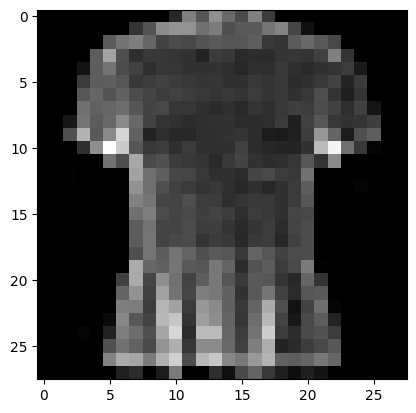

In [34]:
plt.imshow(image.squeeze(), cmap="gray")

In [35]:
torch.manual_seed(42)

model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [36]:
img_tensor = torch.randn(size=(1, 28, 28)).to(device)
img_tensor.device

device(type='cuda', index=0)

In [37]:
# pass image through model
model_2(img_tensor.unsqueeze(dim=0))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Stepping through `nn.Conv2d`

In [38]:
torch.manual_seed(42)

# create a dummy img
images = torch.rand(size=(32, 3, 64, 64))
test_image = images[0]
images.shape

torch.Size([32, 3, 64, 64])

In [39]:
torch.manual_seed(42)
# create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3, # (3, 3)
                       stride=1,
                       padding=0)


# past the data through the convolutional layer
conv_output = conv_layer(test_image.unsqueeze(dim=0))
conv_output.shape


torch.Size([1, 10, 62, 62])

# Stepping through `nn.MaxPool2d()`

In [40]:
print(f"original image shape: {test_image.shape}")
print(f"original image shape with unsqueeze: {test_image.unsqueeze(dim=0).shape}")

# nn.MaxPool2d layer sample
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# pass data through just the conv layer
test_img_conv= conv_layer(test_image.unsqueeze(dim=0))
print(f"shaper after conv layer: {test_img_conv.shape}")

# pass data through the max pool layer
test_img_max_pool = max_pool_layer(test_img_conv)
print(f"shaper after max pool layer: {test_img_max_pool.shape}")

original image shape: torch.Size([3, 64, 64])
original image shape with unsqueeze: torch.Size([1, 3, 64, 64])
shaper after conv layer: torch.Size([1, 10, 62, 62])
shaper after max pool layer: torch.Size([1, 10, 31, 31])


In [41]:
torch.manual_seed(42)

# random tensor with similar num of dim's to our img
random_tensor = torch.randn(size=(1, 1, 2, 2))

# create the max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

max_pool_tensor = max_pool_layer(random_tensor)
random_tensor, random_tensor.shape, max_pool_tensor, max_pool_tensor.shape

(tensor([[[[0.3367, 0.1288],
           [0.2345, 0.2303]]]]),
 torch.Size([1, 1, 2, 2]),
 tensor([[[[0.3367]]]]),
 torch.Size([1, 1, 1, 1]))

# Setup loss function and optimizer

In [42]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

# Training and testing `model 2` using our training and test functions

In [43]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# time
from timeit import default_timer as timer
train_time_model_2 = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model= model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)


train_time_end_model_2 = timer()
total_time = train_time(start=train_time_model_2, end=train_time_end_model_2, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
loss:0.39477 | acc:86.06%
Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
loss:0.35386 | acc:87.36%
Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
loss:0.32357 | acc:88.45%
Train time on cuda: 33.955 seconds


In [44]:
model_results = eval_mode(model=model_2,
                          data_loader=test_dataloader,
                          loss_fn=loss_fn,
                          accuracy_fn=accuracy_fn)

model_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'FashionMNISTModelV2': {'loss': 0.3235681354999542,
  'accuracy': 88.44848242811501}}

In [45]:
# compare model results and training time
import pandas as pd
pd.DataFrame(model_results)

,FashionMNISTModelV2
loss,0.323568
accuracy,88.448482


# Make and evaluate random prediction with the best model


In [46]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device:torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # forward pass
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # move to cpu for further calculations
      pred_probs.append(pred_prob.cpu())

  # turn pred_probs into a tensor
  return torch.stack(pred_probs)


In [47]:
import random
random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)


test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

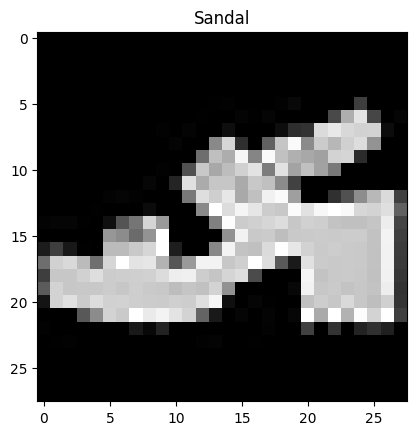

In [48]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [49]:
# make predictions
pred_probs = make_predictions(model=model_2, data=test_samples)
pred_probs[:2]

tensor([[5.4512e-08, 5.9935e-08, 1.8154e-08, 2.2125e-08, 1.6375e-08, 9.9992e-01,
         3.6748e-08, 1.0688e-05, 1.9797e-05, 4.8356e-05],
        [2.3922e-02, 8.9265e-01, 3.9719e-04, 7.0219e-02, 3.5923e-03, 5.9233e-05,
         8.8185e-03, 1.7140e-04, 1.1311e-04, 6.1179e-05]])

In [50]:
# comvert pred prob to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

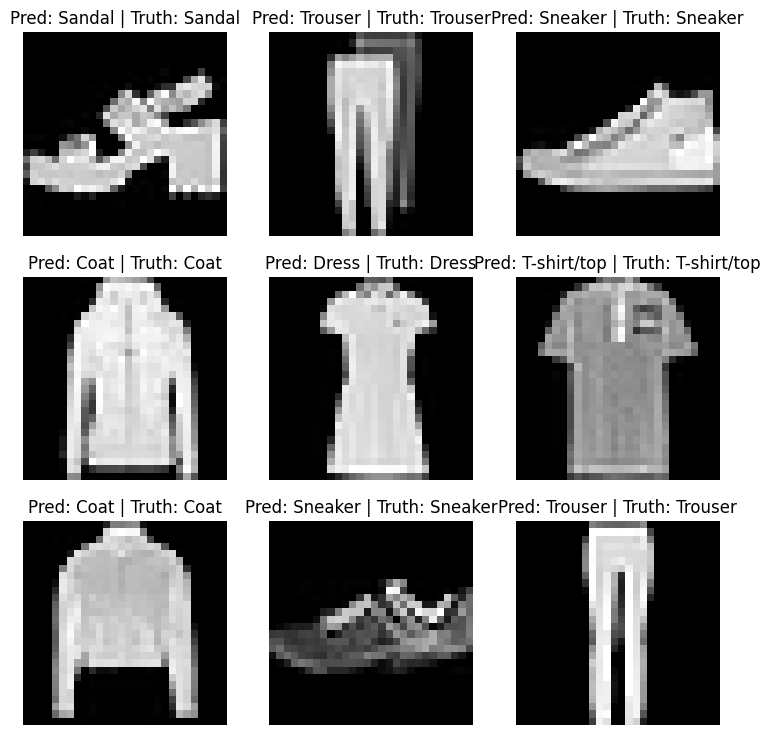

In [51]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # create subplot - for each sample
  plt.subplot(nrows, ncols, i+1)

  # plot the target img
  plt.imshow(sample.squeeze(), cmap="gray")

  # set the title
  plt.title(f"Pred: {class_names[pred_classes[i]]} | Truth: {class_names[test_labels[i]]}")

  plt.axis(False)

# Making a confusion matrix for further prediction evaluation

1. make predictions with our trained model on the test dataset
2. make a confusion matrix `torchmetrics.ConfusionMatrix`
3. plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix`

In [52]:
y_predictions = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="making predictions..."):
    X, y = X.to(device), y.to(device)
    y_logit = model_2(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_predictions.append(y_pred.cpu())

# concatenate list of predictions intoa tensor
y_predictions = torch.cat(y_predictions)
y_predictions


making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 2])

In [53]:
import mlxtend

In [54]:
try:
  import torchmetrics, mlxtend
  print("torchmetrics and mlxtend are already installed")
except:
  !pip install torchmetrics mlxtend --quiet
  import torchmetrics, mlxtend


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.5 MB/s eta 0:00:00


In [55]:
import mlxtend

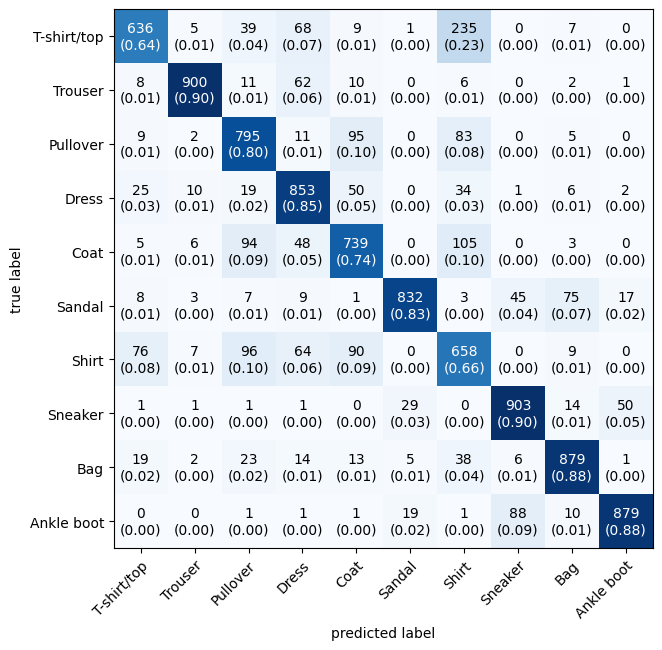

In [56]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_predictions, target=test_data.targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                show_normed=True,
                                figsize=(10, 7),
                                class_names=class_names,
                                cmap=plt.cm.Blues,
                                colorbar=False)

In [57]:
confmat_tensor

tensor([[636,   5,  39,  68,   9,   1, 235,   0,   7,   0],
        [  8, 900,  11,  62,  10,   0,   6,   0,   2,   1],
        [  9,   2, 795,  11,  95,   0,  83,   0,   5,   0],
        [ 25,  10,  19, 853,  50,   0,  34,   1,   6,   2],
        [  5,   6,  94,  48, 739,   0, 105,   0,   3,   0],
        [  8,   3,   7,   9,   1, 832,   3,  45,  75,  17],
        [ 76,   7,  96,  64,  90,   0, 658,   0,   9,   0],
        [  1,   1,   1,   1,   0,  29,   0, 903,  14,  50],
        [ 19,   2,  23,  14,  13,   5,  38,   6, 879,   1],
        [  0,   0,   1,   1,   1,  19,   1,  88,  10, 879]])

# Save and load the model

In [58]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save
MODEL_NAME = "pytorch_computer_vision.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/pytorch_computer_vision.pth


In [59]:
# Create new instance
torch.manual_seed(42)

laoded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_names))

laoded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))
laoded_model_2.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [60]:
torch.manual_seed(42)

laoded_model_2_results = eval_mode(model=laoded_model_2,
                          data_loader=test_dataloader,
                          loss_fn=loss_fn,
                          accuracy_fn=accuracy_fn)

laoded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'FashionMNISTModelV2': {'loss': 0.3235681354999542,
  'accuracy': 88.44848242811501}}

In [61]:
model_results

{'FashionMNISTModelV2': {'loss': 0.3235681354999542,
  'accuracy': 88.44848242811501}}